True minimizer: [0. 0.] f(x*) = 0.0
Good algorithm final point: [-1.69283652e-11 -9.83722935e-13] ||grad|| = 1.957908655093878e-11
Bad algorithm final point: [ 1.55012488 -0.04216328] ||grad|| = 1.6064436895004712


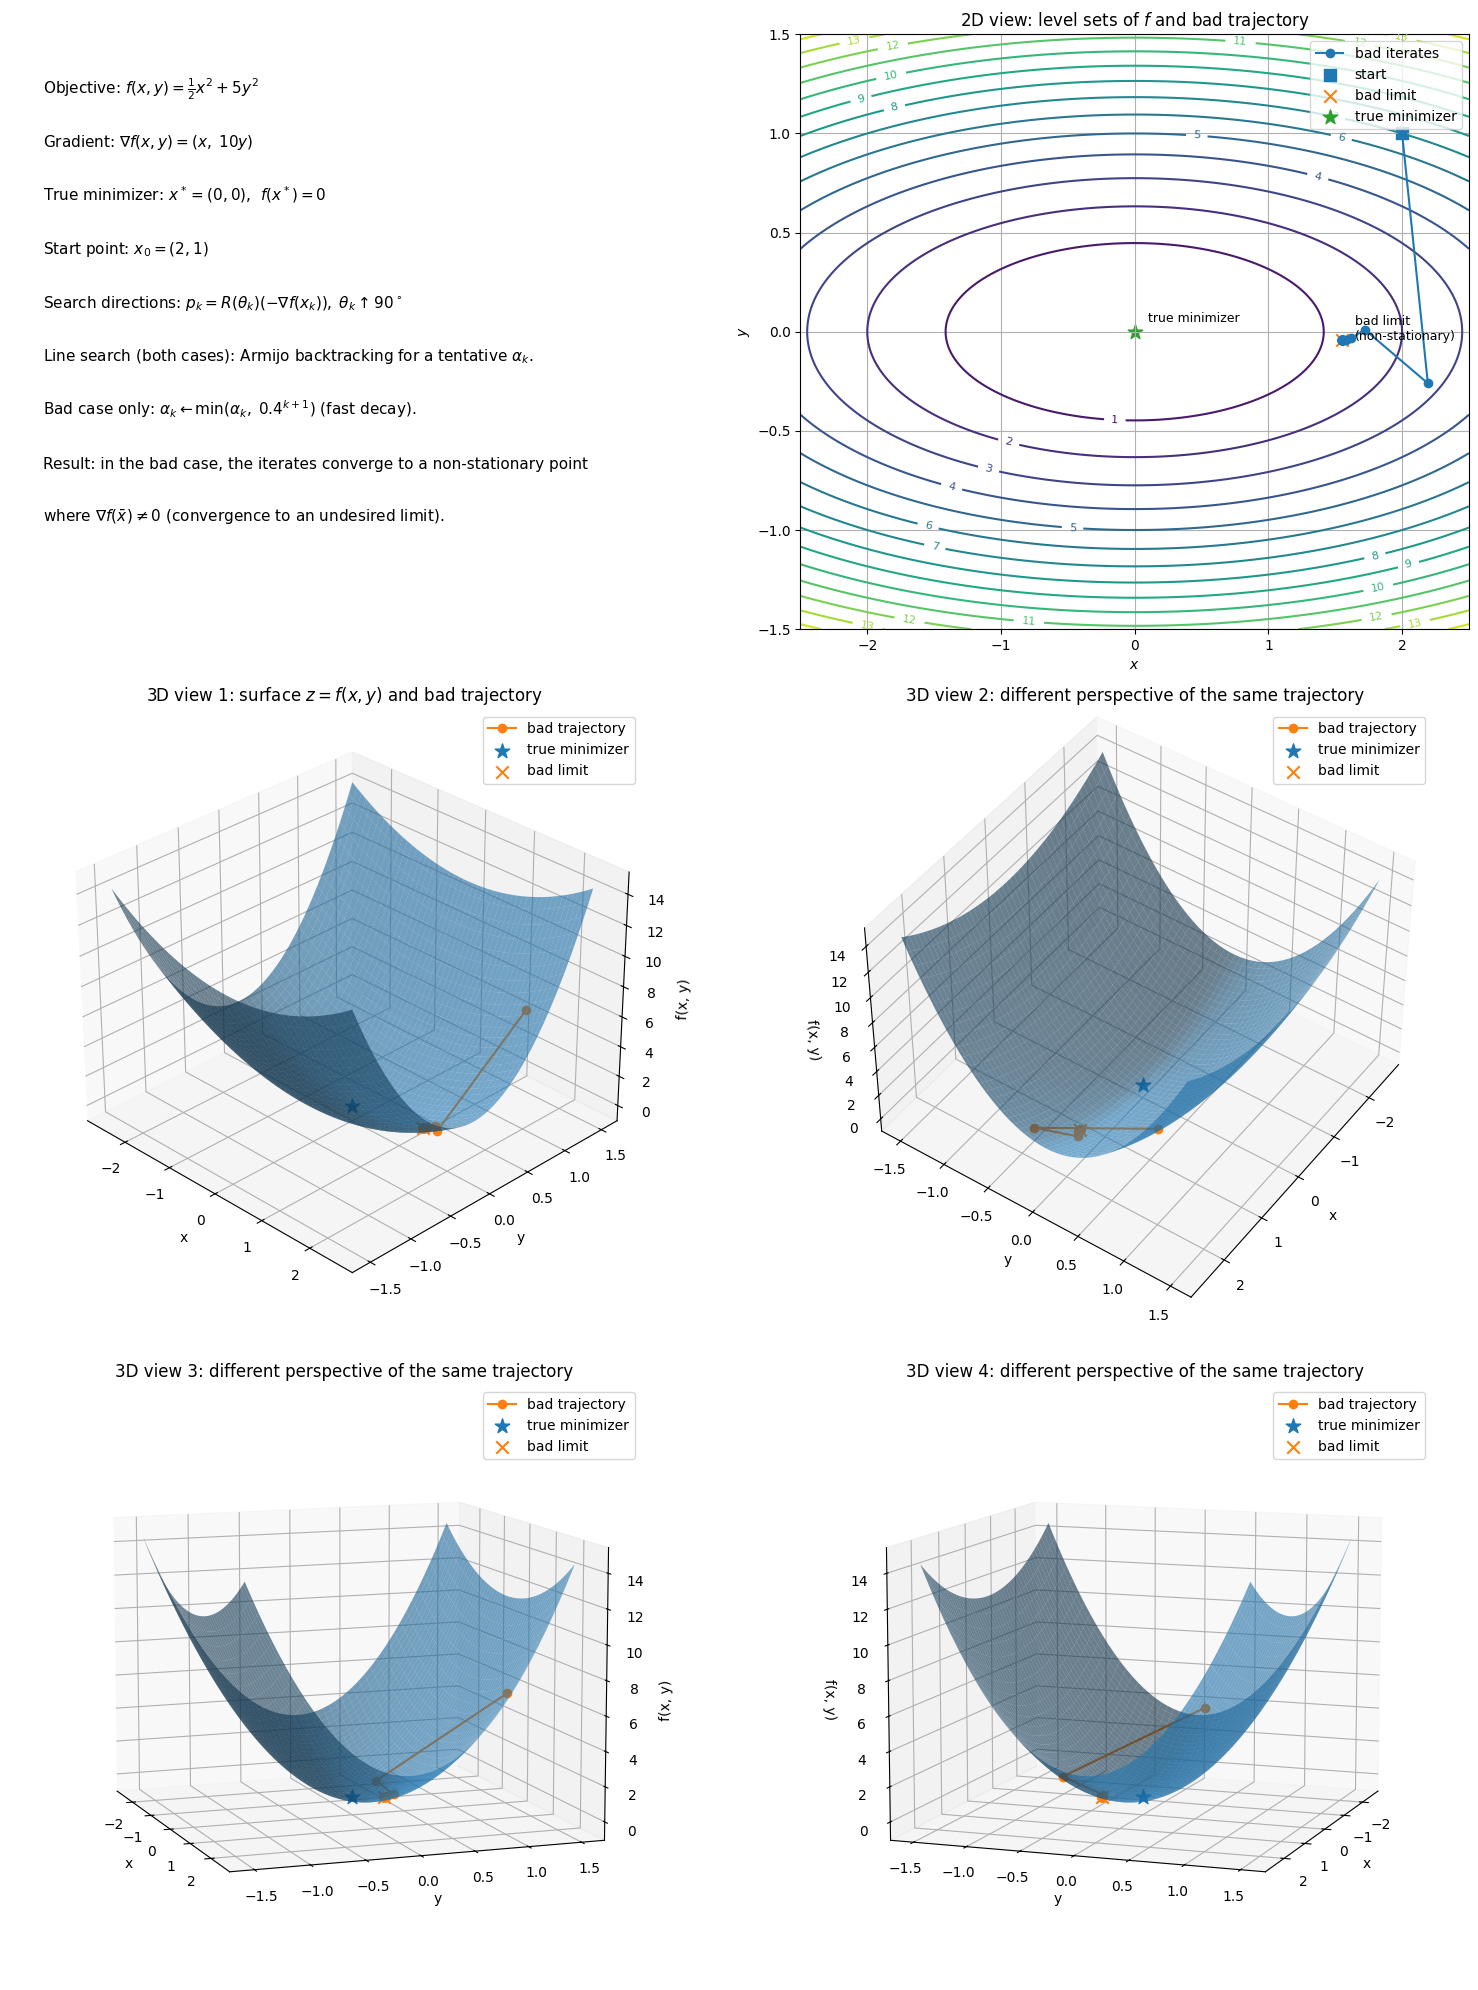

In [47]:
import numpy as np
import matplotlib.pyplot as plt
# ------------ Problem definition ------------

def f(x):
    """Objective function f(x, y) = 0.5 x^2 + 5 y^2."""
    return  0.5*x[0]**2 + 5.0 * x[1]**2

def grad_f(x):
    """Gradient of f."""
    return np.array([x[0], 10.0 * x[1]])

def rotated_descent_direction(x, theta_deg):
    """
    Construct a descent direction by rotating the negative gradient by theta_deg.
    For theta_deg < 90, this is still a descent direction.
    """
    g = grad_f(x)
    d = -g  # steepest descent direction
    theta = np.deg2rad(theta_deg)
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta),  np.cos(theta)]])
    p = R @ d
    return p

def backtracking_line_search(x, p, c1=1e-4, beta=0.5, max_iter=50):
    """
    Standard Armijo backtracking line search.
    Finds alpha > 0 such that: f(x + alpha p) <= f(x) + c1 * alpha * grad_f(x)^T p
    """
    alpha = 1.0
    fx = f(x)
    gTp = np.dot(grad_f(x), p)
    for _ in range(max_iter):
        if f(x + alpha * p) <= fx + c1 * alpha * gTp:
            break
        alpha *= beta
        if alpha < 1e-12:
            break
    return alpha

def run_algorithm(alpha_cap=False, max_iter=60):
    """
    Run the artificial line-search-like algorithm.

    alpha_cap = False  -> "good" case:
        - descent directions: p_k = R(theta_k)(-grad f(x_k)),
          with theta_k increasing from 20° towards 90°.
        - step sizes alpha_k chosen by Armijo backtracking.

    alpha_cap = True   -> "bad" case:
        - same descent directions p_k as above,
        - BUT step sizes are additionally capped by 0.4^(k+1),
          which forces alpha_k to decay very fast and may freeze the iterates
          before reaching the true minimizer.
    """
    x0 = np.array([2.0, 1.0])  # starting point
    # x0 = np.array([2.8, 1.1])  # starting point
    x = x0.copy()
    path = [x.copy()]
    alphas = []
    angles = []
    grad_norms = []

    for k in range(max_iter):
        # Rotation angle increases towards 90 degrees
        theta_k = 20.0+70.0 * ((k / max_iter)**5)
        p_k = rotated_descent_direction(x, theta_k)

        gTp = np.dot(grad_f(x), p_k)
        if gTp >= 0:
            print("Warning: lost descent at iteration", k)
            break

        # tentative step size from Armijo backtracking
        alpha_k = backtracking_line_search(x, p_k)

        if alpha_cap:
            # BAD design: force the step sizes to decay very fast
            # so that the algorithm can "freeze" before reaching the true minimizer
            alpha_k = min(alpha_k, 0.4**(k + 1))

        x = x + alpha_k * p_k

        path.append(x.copy())
        alphas.append(alpha_k)
        angles.append(theta_k)
        grad_norms.append(np.linalg.norm(grad_f(x)))

    return np.array(path), np.array(alphas), np.array(angles), np.array(grad_norms)


# ------------ Run both variants: good vs bad ------------

path_bad, alphas_bad, angles_bad, gn_bad = run_algorithm(alpha_cap=True,  max_iter=50)
path_good, alphas_good, angles_good, gn_good = run_algorithm(alpha_cap=False, max_iter=50)

x_star = np.array([0.0, 0.0])
final_bad = path_bad[-1]
final_good = path_good[-1]

print("True minimizer:", x_star, "f(x*) =", f(x_star))
print("Good algorithm final point:", final_good, "||grad|| =", np.linalg.norm(grad_f(final_good)))
print("Bad algorithm final point:", final_bad, "||grad|| =", np.linalg.norm(grad_f(final_bad)))

# ------------ Combined Figure ------------

# Create a single figure with 3 rows and 2 columns
fig = plt.figure(figsize=(15, 20))

# Subplot for Figure 1: Text / Math + method description
ax1 = fig.add_subplot(3, 2, 1)
ax1.axis("off")

text_lines = [
    r"Objective: $f(x, y) = \frac{1}{2} x^2 + 5 y^2$",
    r"Gradient: $\nabla f(x, y) = (x,\; 10y)$",
    r"True minimizer: $x^* = (0, 0)$,  $f(x^*) = 0$",
    r"Start point: $x_0 = (2, 1)$",
    r"Search directions: $p_k = R(\theta_k)(-\nabla f(x_k)),\; \theta_k \uparrow 90^\circ$",
    r"Line search (both cases): Armijo backtracking for a tentative $\alpha_k$.",
    r"Bad case only: $\alpha_k \leftarrow \min(\alpha_k,\; 0.4^{k+1})$ (fast decay).",
    r"Result: in the bad case, the iterates converge to a non-stationary point",
    r"where $\nabla f(\bar x) \neq 0$ (convergence to an undesired limit)."
]

y_pos = 0.9
for line in text_lines:
    ax1.text(0.05, y_pos, line, fontsize=11, transform=ax1.transAxes)
    y_pos -= 0.09

# Subplot for Figure 2: 2D contour plot and trajectory (bad case)
ax2 = fig.add_subplot(3, 2, 2)

x_vals = np.linspace(-2.5, 2.5, 200)
y_vals = np.linspace(-1.5, 1.5, 200)
X, Y = np.meshgrid(x_vals, y_vals)
Z = f([X,Y])

cs = ax2.contour(X, Y, Z, levels=15)
ax2.clabel(cs, inline=True, fontsize=8)

# Plot the bad path
ax2.plot(path_bad[:, 0], path_bad[:, 1], marker="o", linestyle="-", label="bad iterates")

# Show the starting point, bad limit, and true minimizer
ax2.scatter(path_bad[0, 0], path_bad[0, 1], marker="s", s=70, label="start")
ax2.scatter(final_bad[0], final_bad[1], marker="x", s=80, label="bad limit")
ax2.scatter(x_star[0], x_star[1], marker="*", s=120, label="true minimizer")

# Annotate
ax2.text(final_bad[0] + 0.1, final_bad[1],
         "bad limit\n(non-stationary)", fontsize=9)
ax2.text(x_star[0] + 0.1, x_star[1] + 0.05,
         "true minimizer", fontsize=9)

ax2.set_xlabel(r"$x$")
ax2.set_ylabel(r"$y$")
ax2.set_title("2D view: level sets of $f$ and bad trajectory")
ax2.legend(loc="upper right")
ax2.grid(True)

# Subplots for Figures 3, 4, 5, 6: 3D surface and trajectory (bad case)
ax3 = fig.add_subplot(3, 2, 3, projection='3d')
ax4 = fig.add_subplot(3, 2, 4, projection='3d')
ax5 = fig.add_subplot(3, 2, 5, projection='3d')
ax6 = fig.add_subplot(3, 2, 6, projection='3d')

Z_path_bad = np.array([f(p) for p in path_bad])

# Plot for ax3 (original Figure 3 content)
ax3.plot_surface(X, Y, Z, alpha=0.6, linewidth=0, antialiased=True)
ax3.plot(path_bad[:, 0], path_bad[:, 1], Z_path_bad,
         marker="o", linestyle="-", label="bad trajectory")
ax3.scatter(x_star[0], x_star[1], f(x_star),
            marker="*", s=120, label="true minimizer")
ax3.scatter(final_bad[0], final_bad[1], f(final_bad),
            marker="x", s=80, label="bad limit")
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_zlabel("f(x, y)")
ax3.set_title("3D view 1: surface $z=f(x,y)$ and bad trajectory")
ax3.legend()
ax3.view_init(elev=30, azim=-45)

# Plot for ax4 (original Figure 4 content)
ax4.plot_surface(X, Y, Z, alpha=0.6, linewidth=0, antialiased=True)
ax4.plot(path_bad[:, 0], path_bad[:, 1], Z_path_bad,
         marker="o", linestyle="-", label="bad trajectory")
ax4.scatter(x_star[0], x_star[1], f(x_star),
            marker="*", s=120, label="true minimizer")
ax4.scatter(final_bad[0], final_bad[1], f(final_bad),
            marker="x", s=80, label="bad limit")
ax4.set_xlabel("x")
ax4.set_ylabel("y")
ax4.set_zlabel("f(x, y)")
ax4.set_title("3D view 2: different perspective of the same trajectory")
ax4.legend()
ax4.view_init(elev=45, azim=35)

# Plot for ax5 (original Figure 3 content, third row left)
ax5.plot_surface(X, Y, Z, alpha=0.6, linewidth=0, antialiased=True)
ax5.plot(path_bad[:, 0], path_bad[:, 1], Z_path_bad,
         marker="o", linestyle="-", label="bad trajectory")
ax5.scatter(x_star[0], x_star[1], f(x_star),
            marker="*", s=120, label="true minimizer")
ax5.scatter(final_bad[0], final_bad[1], f(final_bad),
            marker="x", s=80, label="bad limit")
ax5.set_xlabel("x")
ax5.set_ylabel("y")
ax5.set_zlabel("f(x, y)")
ax5.set_title("3D view 3: different perspective of the same trajectory")
ax5.legend()
ax5.view_init(elev=10, azim=-20)

# Plot for ax6 (original Figure 4 content, third row right)
ax6.plot_surface(X, Y, Z, alpha=0.6, linewidth=0, antialiased=True)
ax6.plot(path_bad[:, 0], path_bad[:, 1], Z_path_bad,
         marker="o", linestyle="-", label="bad trajectory")
ax6.scatter(x_star[0], x_star[1], f(x_star),
            marker="*", s=120, label="true minimizer")
ax6.scatter(final_bad[0], final_bad[1], f(final_bad),
            marker="x", s=80, label="bad limit")
ax6.set_xlabel("x")
ax6.set_ylabel("y")
ax6.set_zlabel("f(x, y)")
ax6.set_title("3D view 4: different perspective of the same trajectory")
ax6.legend()
ax6.view_init(elev=10, azim=20)

plt.tight_layout()
plt.show()